# Inference of Company X and its SKU's

@roman avj

19 feb 2024

---
# Settings

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

In [2]:
# get configs
with open('../config.yaml', 'r') as f:
    config = yaml.safe_load(f)


---
# Data

In [3]:
def to_millions(df: pd.DataFrame) -> pd.DataFrame:
    # copy
    df = df.copy()

    # get cols that are not the zone
    cols_not_zone = [col for col in df.columns if col != 'ZONA']

    # each row to millions
    df[cols_not_zone] = df[cols_not_zone].apply(lambda x: x/1e6)
    return df

In [9]:
# load sales
df_sales_raw = pd.read_excel(config['eda']['sales']).pipe(to_millions).set_index('ZONA')
# drop '2022-12' column (explanaition on the EDA)
df_sales = df_sales_raw.drop(columns='2022-12').copy()

# load top 200 sku's
df_skus = pd.read_excel(config['eda']['sku']).pipe(to_millions).set_index('ZONA')

In [13]:
# look at the data
df_sales.head()

,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,...,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11
ZONA,,,,,,,,,,,,,,,,,,,,,
1,9.873875,9.540396,11.220031,9.876677,11.490076,10.918880,9.356538,10.492577,9.780397,9.145581,...,14.464262,16.440672,14.861549,16.929555,16.143667,17.596228,17.728184,17.060831,17.362823,23.164561
2,5.228411,5.547264,6.591042,6.239016,6.401350,6.155254,5.681139,6.159061,6.492854,7.491982,...,8.925630,10.483419,7.769870,8.088835,8.132009,8.938827,9.674604,8.961393,9.047043,10.220360
3,7.268431,6.507043,8.361120,6.560573,7.608588,6.898334,6.659884,7.455095,6.560414,9.108559,...,8.842998,11.443755,10.184570,11.251412,11.193919,10.444169,9.281830,10.652627,11.604626,10.057233
4,7.066948,6.687970,8.133912,6.676082,8.175272,7.376892,6.992252,7.745622,7.919577,8.084340,...,9.802692,12.335586,10.174585,10.723091,12.077457,11.865325,11.451469,11.467568,10.206208,10.985148
5,5.303134,5.133612,5.955766,5.617922,5.670728,5.583939,5.752821,5.651055,6.047120,5.598954,...,7.668836,8.084046,6.845954,7.123049,8.097289,7.751273,7.292691,7.368594,8.109758,7.908011


In [14]:
# look at the data
df_skus.head()

,SKU_000001,SKU_000002,SKU_000003,SKU_000004,SKU_000005,SKU_000006,SKU_000007,SKU_000008,SKU_000009,SKU_000010,...,SKU_000191,SKU_000192,SKU_000193,SKU_000194,SKU_000195,SKU_000196,SKU_000197,SKU_000198,SKU_000199,SKU_000200
ZONA,,,,,,,,,,,,,,,,,,,,,
1,1.212099,1.662853,3.136545,2.770269,6.715570,0.478408,4.270451,3.739209,3.297076,1.447419,...,1.759146,1.293314,2.408767,0.459970,2.309683,6.976844,5.182221,2.359301,0.960081,0.000000
2,1.388387,0.918344,1.633432,0.595710,8.753465,0.041274,2.404877,3.800591,1.280679,1.029731,...,0.531473,0.000000,0.264903,0.107979,1.094261,1.872017,0.973966,0.632653,0.888074,0.853632
3,1.779890,2.064487,1.685203,0.315957,5.675680,0.862358,0.301434,7.002510,0.906169,0.932483,...,0.346763,0.000000,1.820579,0.888135,0.709625,1.108717,0.960915,0.407213,0.996818,1.131421
4,3.101737,3.063763,2.791287,0.104755,2.734516,1.642425,1.644228,5.621550,1.458318,1.441692,...,0.124046,0.000000,0.541028,2.645447,0.453179,1.507338,0.366661,0.429814,1.644299,0.487546
5,1.391194,2.512046,0.619912,0.285202,16.177937,0.033597,1.219657,5.578319,1.170495,1.350450,...,0.182338,1.365828,0.085603,0.262775,0.898682,1.809659,0.125969,0.271253,2.428611,0.764751


# Time Series Prediction

## General TS

<Axes: >

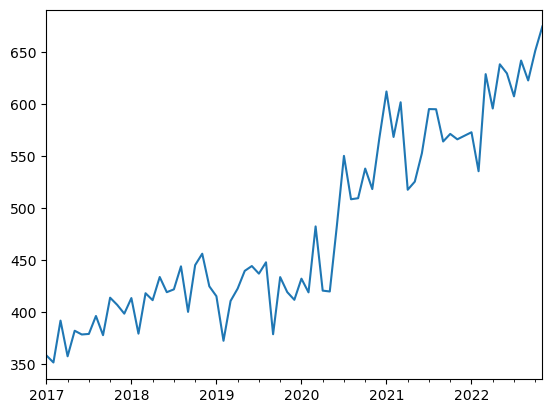

In [57]:
# look time series of the total sales
ts_general = df_sales.sum()
ts_general.index = pd.to_datetime(ts_general.index)  # convert to datetime
ts_general.name = 'total_sales'
ts_general.plot()

### Finding best ARIMA model using Guerrero's method

### Step 1: Find the differencial of the time series

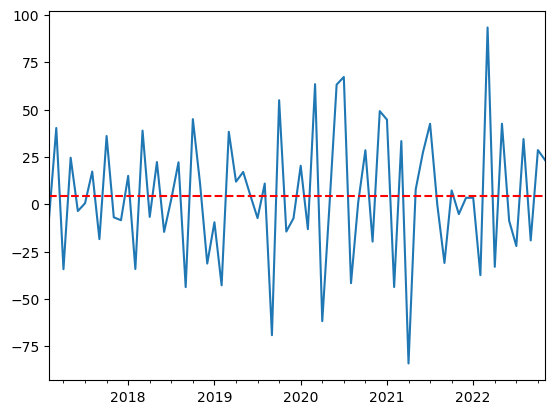

In [23]:
# Step 1: difference the time series
ts_general_diff = ts_general.diff().dropna()

# plot the time series
ts_general_diff.plot()
# add mean
plt.axhline(ts_general_diff.mean(), color='r', linestyle='--')

In [56]:
# Apply Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

# apply the test
adf_result = adfuller(ts_general_diff)
# print the result
print(adf_result)

(-7.055700229944167, 5.382522103475021e-10, 3, 66, {'1%': -3.5335601309235605, '5%': -2.9064436883991434, '10%': -2.590723948576676}, 568.8252626661746)


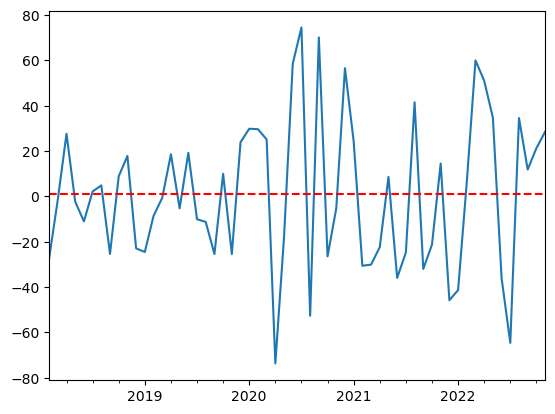

In [76]:
# Step 1.1: difference the time series seasonal and non-seasonal
ts_general_diff = ts_general.diff(periods=12).diff().dropna()

# plot the time series
ts_general_diff.plot()
# add mean
plt.axhline(ts_general_diff.mean(), color='r', linestyle='--')

In [77]:
# apply the test
adf_result = adfuller(ts_general_diff)
# print the result
print(adf_result)

(-6.53078666587547, 9.882141897427127e-09, 1, 56, {'1%': -3.552928203580539, '5%': -2.9147306250000002, '10%': -2.595137155612245}, 463.4908868243082)


**Notes**:
1. The time series looks stationary and unseasonal
2. However, the variance maybe is not constant so we must apply a transformation to stabilize the variance
3. The Dickey Fuller test is not significant, so we can't reject the null hypothesis of non-stationarity
4. It looks best the model with only stationary differencial.

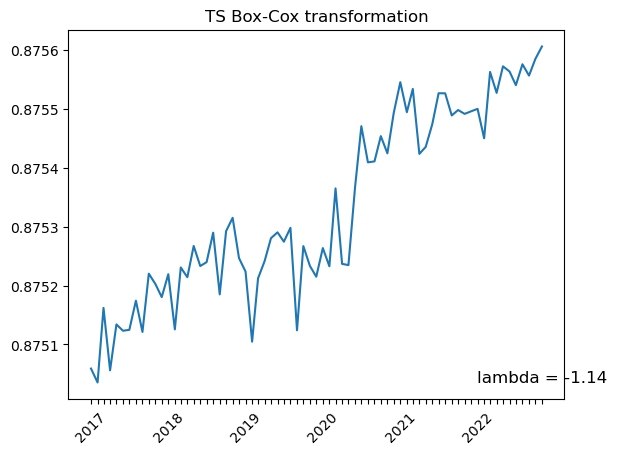

In [53]:
# Step 2: Apply power transformation before the difference
from sklearn.preprocessing import PowerTransformer

# create the transformer
pt = PowerTransformer(method='box-cox', standardize=False)
# fit the transformer
ts_general_boxcox = pt.fit_transform(ts_general.values.reshape(-1, 1))
# convert to pandas series
ts_general_boxcox = pd.Series(ts_general_boxcox.flatten(), index=ts_general.index)

# plot the time series
plt.plot(ts_general_boxcox)
plt.title('TS Box-Cox transformation')
# annotate the lambda value
plt.text(ts_general_boxcox.index.max(), ts_general_boxcox.min(), f'lambda = {pt.lambdas_[0]:.2f}', fontsize=12, ha='center')
# add xticks as dates but only show each year
plt.xticks(
    ts_general_boxcox.index,
    labels=[x.strftime('%Y') if x.month == 1 else '' for x in ts_general_boxcox.index],
    rotation=45
    )
plt.show()


#### Step 2: Find the best transformation

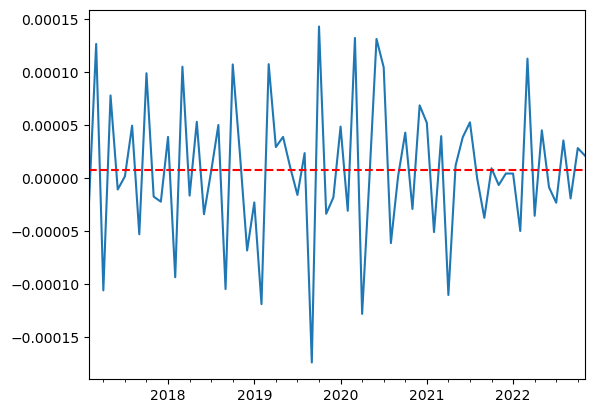

In [54]:
# Step 1: difference the time series
ts_general_boxcox_diff = ts_general_boxcox.diff().dropna()

# plot the time series
ts_general_boxcox_diff.plot()
# add mean
plt.axhline(ts_general_boxcox_diff.mean(), color='r', linestyle='--')

In [55]:
# apply the test
adf_result = adfuller(ts_general_boxcox_diff)
# print the result
print(adf_result)

(-2.053254374864808, 0.26372163326115666, 11, 58, {'1%': -3.548493559596539, '5%': -2.912836594776334, '10%': -2.594129155766944}, -966.7956974239128)


**Notes**:
- Much better variance
- By the Dicket-Fuller test, the time series is can be non-stationary.
- For best pracices, we should stay with the original time series.

In [ ]:
#### Step 3: 